# **Trust by Interrogation**

**Introduction**

In this tutorial, we will go step-by-step throught a model interrogation process that:



1.   Characterises an instances difficulty using a simple instance hardness metric representative of the likelihood an instance will be misclassified
2.   Calculates 4 hardness measures, each representing a source of difficulty from a data perspective
3.   Performs a correlational analysis that identifies which measure most relates to misclassifications within the current task
4.   Identifies which model best handles the source of difficulty associated with misclassifications 

# **Generating Some Data and Predictions**


Load the data:

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/data/diabetic_preprocessed.csv")
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0


Generate the dataset:

In [ ]:
# address smaller group sizes
df = df.query("gender != 'Unknown/Invalid'") # drop gender group Unknown/Invalid
df["race_all"] = df["race"] # retain the original race as race_all
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"}) # merge Asian+Hispanic+Other 

#  our target variable is readmission within 30 days
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]

Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

# drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies")
Xf = df.drop(columns=[
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
])
X = pd.get_dummies(Xf)

# normalise the non-categorical features to be within 0 and 1
from sklearn.preprocessing import MinMaxScaler

for col in X.columns:
  if len(X[col].unique()) > 2:
    X[col] = MinMaxScaler().fit_transform(X[col].values.reshape(-1,1))

column_names = X.columns
X.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,...,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0.000000,0.305344,0.000000,0.0000,0.000000,False,False,False,False,False,...,1,0,0,1,0,0,0,1,1,0
1,0.153846,0.442748,0.000000,0.2125,0.533333,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
2,0.076923,0.076336,0.833333,0.1500,0.333333,False,False,False,True,True,...,1,0,0,1,0,0,0,1,0,1
3,0.076923,0.328244,0.166667,0.1875,0.400000,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
4,0.000000,0.381679,0.000000,0.0875,0.266667,False,False,False,False,False,...,1,0,0,0,1,0,1,0,0,1


## ***Use partial data for a fast runing***

**Visualise the dataset**

In [ ]:
import numpy as np
DataNum = 500 # use partial data for fast runing
X = X[ : DataNum] + 0
y = Y[ : DataNum] + 0
X = np.array(X)
y = np.array(y)

Text(0, 0.5, 'PC2')

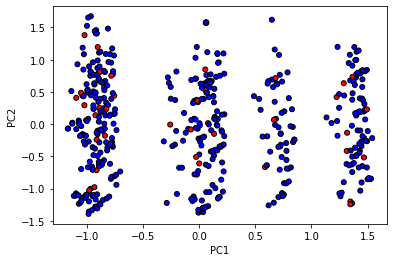

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

X_pca = PCA(n_components=2).fit_transform(X)

X_ = X_pca[ : DataNum] + 0
y_ = y[ : DataNum] + 0
X_ = np.array(X_)
y_ = np.array(y_)

colors = ['b','r']
color = []
for c in y_:
  color.append(colors[c])

pyplot.scatter(X_[:, 0], X_[:, 1], marker='o', c=color,
            s=25, edgecolor='k')
pyplot.xlabel('PC1')
pyplot.ylabel('PC2')

**Generate predictions and probabilites**

We will now generate predictions and classification probabilites using four classifiers (Logistic Regression, SVM, KNN and Random Forest). To generate an output for each instance we will apply leave-one-out cross-validation.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

Before generating our predictions, it is important to know the class distribution. Unsurprisingly, the number of patients who are readmitted outweight those who are. Therefore, each classifiers must be weighted to avoid biasing the the predictions towards the majority class.

In [ ]:
print('Class 0: ', np.shape(y[np.where(y==0)])[0])
print('Class 1: ', np.shape(y[np.where(y==1)])[0])

class_weights = {0:0.1,1:1}

Class 0:  457
Class 1:  43


In [ ]:
LR = LogisticRegression(C=100, class_weight=class_weights,max_iter=100)
SVM = SVC(C=10, probability=True,class_weight=class_weights,kernel='rbf')
KNN = KNeighborsClassifier(n_neighbors=5,weights='distance',metric='euclidean')
RF = RandomForestClassifier(class_weight=class_weights, n_estimators=20,max_depth=6)
models = [LR,SVM,KNN,RF]

We generate a prediction for each patient using a leave-one-out cross validation, selecting the best 15 features using the training set.

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(X)

truth = []
predictions = []
probabilities = []

for train_index, test_index in loo.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  truth = np.append(truth, y_test)
  
  y_pred = []
  y_prob = []

  for model in models:
    clf = Pipeline([('selector', SelectKBest(chi2, k=15)), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_hat_pred = clf.predict(X_test)
    y_hat_prob = clf.predict_proba(X_test)[:,1]

    y_pred = np.append(y_pred, y_hat_pred)
    y_prob = np.append(y_prob, y_hat_prob)
  
  try:
    predictions = np.vstack((predictions, y_pred))
    probabilities = np.vstack((probabilities, y_prob))
  except:
    predictions = y_pred
    probabilities = y_prob

**Overall Model Performance**

The global performance of each model, in terms of balanced accuracy and AUROC, is shown below.



In [ ]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from prettytable import PrettyTable

model_names = ['Logistic Regression', 'SVM', 'KNN', 'Random Forest']

performance_table = PrettyTable()
performance_table.field_names = ["Classifier", "Accuracy", "AUROC"]

for i in range(len(model_names)):
  performance_table.add_row([model_names[i], np.round(balanced_accuracy_score(truth, predictions[:,i]),2), np.round(roc_auc_score(truth, probabilities[:,i]),2)])

print(performance_table)

+---------------------+----------+-------+
|      Classifier     | Accuracy | AUROC |
+---------------------+----------+-------+
| Logistic Regression |   0.56   |  0.58 |
|         SVM         |   0.59   |  0.62 |
|         KNN         |   0.53   |  0.62 |
|    Random Forest    |   0.57   |  0.6  |
+---------------------+----------+-------+


The features used to obtain the above performance measures are shown below.

In [ ]:
skb = SelectKBest(chi2, k=15).fit(X,y)
print("Selected Features:")
[print(feature) for feature in skb.get_feature_names_out(column_names)]
X_selected = skb.transform(X)

Selected Features:
num_procedures
had_emergency
had_inpatient_days
had_outpatient_days
age_30-60 years
age_Over 60 years
admission_source_id_Referral
medical_specialty_Family/GeneralPractice
medical_specialty_Other
primary_diagnosis_Musculoskeletal Issues
primary_diagnosis_Respiratory Issues
max_glu_serum_>200
A1Cresult_>7
A1Cresult_Norm
insulin_Up


# **Calculating Instance Hardness**

Now that we have a prediction for each instance in the dataset we can calculate a simple instance hardness score, reflecting how likely an instance is to be misclassified by any given classifier. Instance hardness is calculated, as proposed in Smith et al., using: 

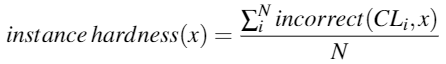

where $x$ refers to a record in the dataset, $N$ refers to the number of classifiers and the function $incorrect(CL_i,x)$ returns 1 if the record $x$ is incorrectly classified by classifier $CL_i$. 

*M. R. Smith and T. Martinez, "Improving classification accuracy by identifying and removing instances that should be misclassified," The 2011 International Joint Conference on Neural Networks, 2011, pp. 2690-2697, doi: https://doi.org/10.1109/IJCNN.2011.6033571*

In [ ]:
correct_classifications = np.zeros((X.shape[0],len(models)))

for column in range(len(models)):
  for row in range(X.shape[0]):
    if (truth[row] == predictions[row,column]):
      correct_classifications[row,column] = 1
    else:
      correct_classifications[row,column] = 0
      
instance_hardness = np.mean(correct_classifications,axis=1)

We can visual instance hardness and inspect where in the feature space instances prove to be more difficult.

Text(0, 0.5, 'PC2')

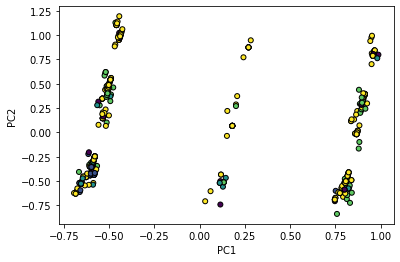

In [ ]:
X_pca = PCA(n_components=2).fit_transform(X_selected)

X_ = X_pca[ : DataNum] + 0
y_ = y[ : DataNum] + 0
X_ = np.array(X_)
y_ = np.array(y_)

pyplot.scatter(X_[:, 0], X_[:, 1], marker='o', c=instance_hardness,
            s=25, edgecolor='k')
pyplot.xlabel('PC1')
pyplot.ylabel('PC2')

# **Calculation of Hardness Measures**

All hardness measure presented in this tutorial are taken from Smith et al., 2014.

*Smith, M.R., Martinez, T. & Giraud-Carrier, C. An instance level analysis of data complexity. Mach Learn 95, 225–256 (2014). https://doi.org/10.1007/s10994-013-5422-z*

**Disjunct Size**

Disjunct size measures the complexity of the decision boundary. Firstly, we generate an unpruned decision tree, and identify which disjust or node and instances lies on that tree. We then compare the size of an instance's node to the largest node in the tree, giving us the discjunct size of an instance. The smaller a disjunct, the more challenging an instance is to correctly classify.

Disjunct size is calculated using:

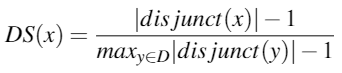

, where the function $disjunct(x)$ returns the disjunct that covers record $x$, $D$ refers to the entire dataset and the functions $disjunct(y)$ returns all disjuncts in the dataset.

In [ ]:
from sklearn.tree import _tree
import importlib

def tree_to_code(tree, tree_name, function_name):
    tree_ = tree.tree_
    feature_name = [i
        for i in tree_.feature
    ]
    with open(tree_name, 'w') as f:
     print(function_name, file=f)

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = 'X['+str(feature_name[node])+']'
            threshold = tree_.threshold[node]
            with open(tree_name, 'a') as f:
              print("{}if {} <= {}:".format(indent, name, threshold), file=f)
            recurse(tree_.children_left[node], depth + 1)
            with open(tree_name, 'a') as f:
              print("{}else:  # if {} > {}".format(indent, name, threshold), file=f)
            recurse(tree_.children_right[node], depth + 1)
        else:
          with open(tree_name, 'a') as f:
            print("{}return {}".format(indent, node), file=f)

    recurse(0, 1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_selected,y)

tree_to_code(clf,'DS_tree.py','def return_DS_disjuncts(X):')

In [ ]:
import DS_tree
import os
Disjuncts = []
for i in range(0, X.shape[0]):
  Disjuncts.append(DS_tree.return_DS_disjuncts(X[i,:]))

unique_disjuncts = set(Disjuncts)
disjunct_sizes = [[x,Disjuncts.count(x)] for x in set(unique_disjuncts)]

disjunct_size = []
for i in range (0,len(disjunct_sizes)):
  disjunct_size.append(disjunct_sizes[i][1])

ds_np = []

for i in range(0, len(Disjuncts)):
  for sizes in range(0,len(unique_disjuncts)):
    if (Disjuncts[i] == disjunct_sizes[sizes][0]):
      if (disjunct_sizes[sizes][1] == max(disjunct_size)):
        ds_np.append(1)
      else:
        ds_np.append((disjunct_sizes[sizes][1]-1)/max(disjunct_size))
DS = np.array(ds_np)
os.remove("DS_tree.py")

**Disjunct Class Percentage**

Disjunct class percentage represents the overlap of an instance based on a subset of its features. This time a pruned decision tree is fitted to our data and rules generated. We then identify the instances in the same disjunct/node as the current instance and identify what percentage of those instances share the same class as the current instance. The lower the discjunct class percentage the more likely an instance is to be misclassified.

Disjunct class percentage is calculated using:

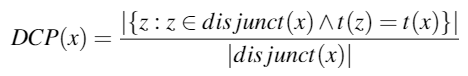

, where $z$ represents the records returned by the functions disjunct(x) belonging to the same class as record $x$.

In [ ]:
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(X_selected,y)

tree_to_code(clf,'DCP_tree.py','def return_DCP_disjuncts(X):')

In [ ]:
import DCP_tree
Disjuncts = []
for i in range(0, X.shape[0]):
  Disjuncts.append(DCP_tree.return_DCP_disjuncts(X[i,:]))

In [ ]:
dcp = []
for i in range(X.shape[0]):
  current_disjunct = np.where(np.array(Disjuncts)==Disjuncts[i])[0]
  current_disjunct = np.delete(current_disjunct, np.where(current_disjunct==i))

  y_disjunct = y[current_disjunct]
  y_curr = y[i]
  y_same = np.where(y_disjunct==y_curr)[0]
  try:
    dcp.append(y_same.shape[0]/y_disjunct.shape[0])
  except:
    dcp.append(1)
DCP = np.array(dcp)
os.remove("DCP_tree.py")

**K-Disagreeing Neighbours**

K-Disagreeing Neighbours reflect the a localised class overlap. K-Disagreeing Neighbours identifies the nearest neighbours to an instances and calculated what percentage of those neighbours are of the same class. We repeat this process for k = 2:17, to mitigate the effect of class size, however, you can change this according to your needs. A greater K-Disagreeing Neighbours score refects a greater possibility of an instance being misclassified.

K-Disagreeing Neighbours is calculated using:

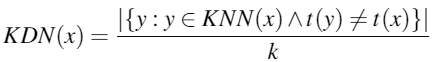

, where the function $KNN(x)$ returns the nearest $k$ neighbours to instance $x$, $t(x)$ returns the class label of record $x$, $y$ represents all instances returned by the functions $KNN(x)$.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from numpy import matlib as mb
scores = np.zeros((X.shape[0],15))
for k in range(2,17):
  nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='kd_tree').fit(X_selected)
  _, indices = nbrs.kneighbors(X_selected)
  neighbors = indices[:, 1:]
  diff_class = mb.repmat(y, k, 1).transpose() != y[neighbors]
  scores[:,k-2] = np.sum(diff_class, axis=1) / k
KDN = np.mean(scores,axis=1)

**Class Likelihood Difference**

Class Likelihood Difference represents the global overlap of an instance against the rest of the dataset using all features. Each feature is of an instances is taken and its probablity of being from each of the classes is calculated. The product of all probabilites in each class is the calculated and the difference between an instances probability of belonging to their actual class vs. the maximum probability of it belonging to another class, based on its features is quantified.

Class Likelihood Difference is calculated as follows:

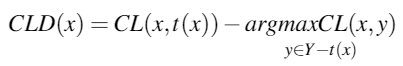

, where the function $CL(x)$ returns the probability of an instance belonging to a certain class, and is derived using equation:

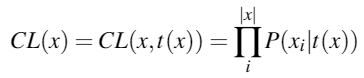

, where $|x|$ is the number of features of instance $x$ and $x_i$ is the value of $x$’s $i$th feature.

In [ ]:
from scipy.stats import norm
CLD = []
classes = np.unique(y)
for i in range(0,X_selected.shape[0]):
  probs = np.zeros((X_selected.shape[1],classes.shape[0]))
  for cls in classes:
    thisClass = np.where(y==cls)

    for feature in range(0,X_selected.shape[1]):

      m = np.mean(X_selected[thisClass,feature])
      d = np.std(X_selected[thisClass,feature])
      if d == 0:
         d = 1
      probs[feature,int(cls)] = norm.pdf(X_selected[i,feature],loc=m,scale=d)

  probsPerClass = np.prod(probs,axis=0)
  
  classIdx = np.where(classes == y[i])[0]
  ppc_i = probsPerClass[classIdx][0]
  probsPerClass = np.delete(probsPerClass,classIdx)
  ppc_max = np.max(probsPerClass)
  CLD.append(ppc_i-ppc_max)

# **Correlational analysis between Instance Hardness and Hardness Measures**

Now that we have our 4 hardness measure, we can calculate the correlation co-efficient between each of them and instance hardness. This will allow us to identify which measure are the source of difficulty within our classification problem.

In [ ]:
import pandas as pd
hardness = np.c_[(instance_hardness*-1)+1,KDN,DCP,CLD,DS]
col_names = ["I_H", "KDN", "DCP", "CLD", "DS"]
hardness_df = pd.DataFrame(data = hardness, columns = col_names)
corr_coef = hardness_df.corr(method='spearman')
corr_coef

,I_H,KDN,DCP,CLD,DS
I_H,1.000000,0.710866,-0.331823,-0.182927,-0.006289
KDN,0.710866,1.000000,-0.346572,-0.171129,0.036740
DCP,-0.331823,-0.346572,1.000000,0.163346,-0.483344
CLD,-0.182927,-0.171129,0.163346,1.000000,0.123569
DS,-0.006289,0.036740,-0.483344,0.123569,1.000000


# **Which Classifier Copes Best?**

To understand how each classifier handles the different sources of difficulty we can incrementally add or remove an instance and see how this impacts the performance of each model.

Firstly, we sort our predictions and truth arrays according to each hardness measure.

In [ ]:
sorted_probabilities_KDN = probabilities[np.argsort(-1*KDN),:]
sorted_probabilities_CLD = probabilities[np.argsort(CLD),:]
sorted_probabilities_DS = probabilities[np.argsort(DS),:]
sorted_probabilities_DCP = probabilities[np.argsort(DCP),:]

sorted_truth_KDN = truth[np.argsort(-1*KDN)]
sorted_truth_CLD = truth[np.argsort(CLD)]
sorted_truth_DS = truth[np.argsort(DS)]
sorted_truth_DCP = truth[np.argsort(DCP)]

Now, we calculate the AUROC, incrementally adding instances. AUROC can be replaced by any metric here, however, be mindful that if you wish to use a metric such as AUROC, both classes will need to be present in your evaluation set to calculate that measure.

In [ ]:
from scipy import signal

def generate_incremental_auroc_scores(X, models, sorted_truth, sorted_predictions):
  scores = np.zeros(((X.shape[0]*2)-1, len(models)))
  for model in range(0,len(models)): 
    for i in range(0,X.shape[0]):
      try:
        scores[i,model] = roc_auc_score(sorted_truth[0:i+1],sorted_predictions[0:i+1,model])
        scores[i+X.shape[0]-1,model] = roc_auc_score(sorted_truth[i:X.shape[0]],sorted_predictions[i:X.shape[0],model])
      except:
        scores[i+X.shape[0]-1,model] = 1
  scores = signal.resample(scores, 9, axis=0)
  return scores

In [ ]:
KDN_scores = generate_incremental_auroc_scores(X, models, sorted_truth_KDN, sorted_probabilities_KDN)
CLD_scores = generate_incremental_auroc_scores(X, models, sorted_truth_CLD, sorted_probabilities_CLD)
DS_scores = generate_incremental_auroc_scores(X, models, sorted_truth_DS, sorted_probabilities_DS)
DCP_scores = generate_incremental_auroc_scores(X, models, sorted_truth_DCP, sorted_probabilities_DCP)

We can see from the plot below, which of our models performs well with respect to the increasing or decreasing influence of each hardness measures. The measure which correlated most strongly with instance hardness should also show the most linear relationship with classification performance in the plot below.

Text(1.2, 0.15, 'Removing patients --> \n with low DCP')

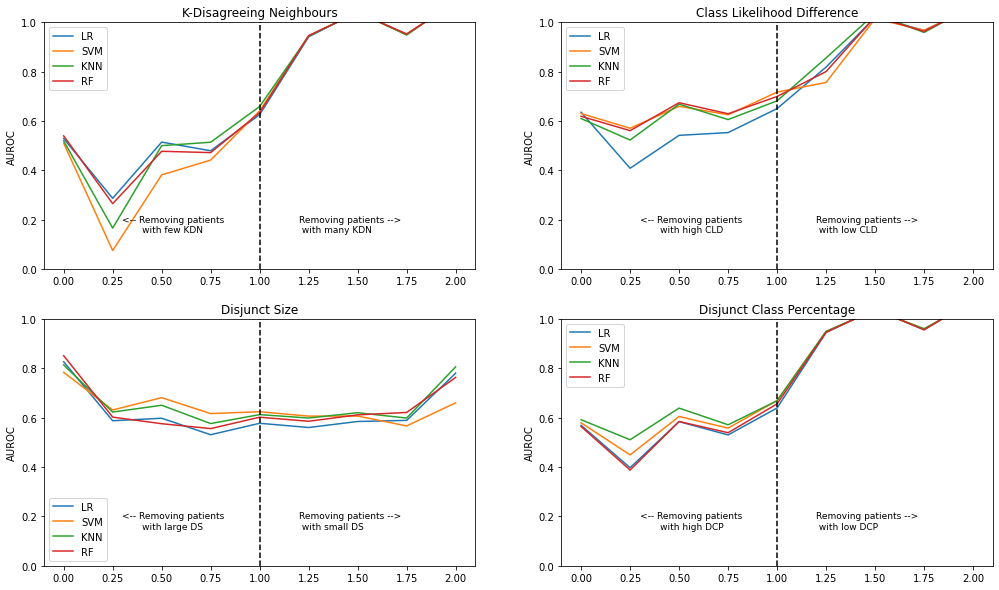

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
x = np.array([0,0.25,0.5,0.75,1,1.25,1.5,1.75,2])
fig.set_figheight(10)
fig.set_figwidth(17)

axs[0, 0].plot(x,KDN_scores)
axs[0, 0].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[0, 0].set_title('K-Disagreeing Neighbours')
axs[0, 0].set_ylabel('AUROC')
axs[0, 0].set_ylim([0,1])
axs[0, 0].axvline(x=1,color='k',linestyle='--')
axs[0, 0].text(0.3, 0.15, "<-- Removing patients \n       with few KDN", fontsize=9)
axs[0, 0].text(1.2, 0.15, "Removing patients --> \n with many KDN", fontsize=9)

axs[0, 1].plot(x,CLD_scores)
axs[0, 1].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[0, 1].set_title('Class Likelihood Difference')
axs[0, 1].set_ylabel('AUROC')
axs[0, 1].set_ylim([0,1])
axs[0, 1].axvline(x=1,color='k',linestyle='--')
axs[0, 1].text(0.3, 0.15, "<-- Removing patients \n       with high CLD", fontsize=9)
axs[0, 1].text(1.2, 0.15, "Removing patients --> \n with low CLD", fontsize=9)

axs[1, 0].plot(x,DS_scores)
axs[1, 0].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[1, 0].set_title('Disjunct Size')
axs[1, 0].set_ylabel('AUROC')
axs[1, 0].set_ylim([0,1])
axs[1, 0].axvline(x=1,color='k',linestyle='--')
axs[1, 0].text(0.3, 0.15, "<-- Removing patients \n       with large DS", fontsize=9)
axs[1, 0].text(1.2, 0.15, "Removing patients --> \n with small DS", fontsize=9)

axs[1, 1].plot(x,DCP_scores)
axs[1, 1].legend(['LR', 'SVM', 'KNN', 'RF'])
axs[1, 1].set_title('Disjunct Class Percentage')
axs[1, 1].set_ylabel('AUROC')
axs[1, 1].set_ylim([0,1])
axs[1, 1].axvline(x=1,color='k',linestyle='--')
axs[1, 1].text(0.3, 0.15, "<-- Removing patients \n       with high DCP", fontsize=9)
axs[1, 1].text(1.2, 0.15, "Removing patients --> \n with low DCP", fontsize=9)

**Conclusion**

Global measures of performance found SVM and KNN to yeild the highest AUROC (AUROC = 0.62). However, through deeper model interrogation, KDN was found to relate most strongly to misclassifications ($\rho$ = 0.71) and among patients with high KDN scores, both KNN and SVM performed poorly compared to Logistic Regression and Random Forest.

Therefore, to ensure more difficult patients have the best chance of being classified correctly, Logistic Regression and Random Forest are better options.